In [317]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline


## Modification de la fonction de score

Définitions :
* Un positif est un label = 1 <=> carrière >= 5 ans.
* Un négatif est un label = 0 <=> carrière < 5 ans.
* Un positif que le modèle de prédiction tague comme positif est appelé un "true positive" TP.
* Un positif que le modèle de prédiction tague comme négatif est appelé un "false negative" FN.
* Un négatif que le modèle de prédiction tague comme positif est appelé un "false positive" FP.
* Un négatif que le modèle de prédiction tague comme négatif est appelé un "true negative" TN.
Explication des scores :
* Le recall = ($\frac{TP}{TP+FN} $) évalue la capacité des modèles à détécter les positifs. Dans notre cas, plus le recall va nous aider pour ne pas rater les joueurs qui ont du potentiel.
* La précision  = ($\frac{TP}{TP+FP}$) évalue la capacité des modèles à détécter les négatifs. Dans notre cas, plus la précision est proche de 1 meilleurs est la qualité des invistissements, c-à-d plus on est sur que le joueur vaut le coup.
* Le f1_score = 2*($\frac{recall*precision}{recall+precision}$) représnete la moyenne harmonique entre les 2 scores précédents.

Dans notre cas, éviter les mauvais investissments et détécter les bons joueurs sont d'importances égales. Il faut combiner alors le recall et la précision pour obtenir un score capable d'évaluer efficacement nos modèles d'où l'intéret du f1_score.


In [318]:
def score_classifier(dataset,classifier,labels, cv, score_function = f1_score):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=cv,random_state=50,shuffle=True)
    #confusion_mat = np.zeros((2,2))
    score = 0
    recall = 0
    precision = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        score += score_function(test_labels, predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        precision += precision_score(test_labels, predicted_labels)
    score/=cv
    recall/=cv
    precision/= cv


    return score, recall, precision

In [319]:
# Load dataset
df = pd.read_csv(".\\nba_logreg.csv", sep = ";")
df = df.fillna(0.0)
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [320]:
# extract names, labels, features names and values

names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

In [67]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)

for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

assert not np.isnan(df_vals).any()

## Regardons la distribution de Labels

1.0    831
0.0    509
Name: TARGET_5Yrs, dtype: int64


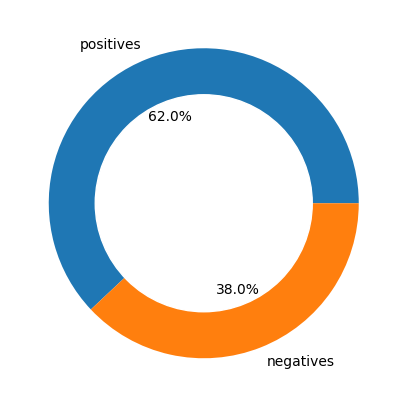

In [135]:
per_class = df['TARGET_5Yrs'].value_counts()

print(per_class)
plt.figure(figsize=(5,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['positives', 'negatives'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

On a environ 2/3 de cas positifs (TARGET_5Yrs = 1) et 1/3 de cas négatifs (TARGET_5Yrs = 0), on peut alors déduire que le dataset ne présente aucun déséquilibre dramatique. Cependant il ne faut pas négliger cette différence parce que ça peut affecter la lecture de la matrice de confusion

## Features selection & Pre_processing

Cette étape a un double objectif :
    1 - l'élimination des metriques non pertinantes.
    2 - potentiellement la génèration de nouvelles métriques pour optimiser la prédiction.



Commencons par le calcul de la matrice de corrélation de nos données

<AxesSubplot:>

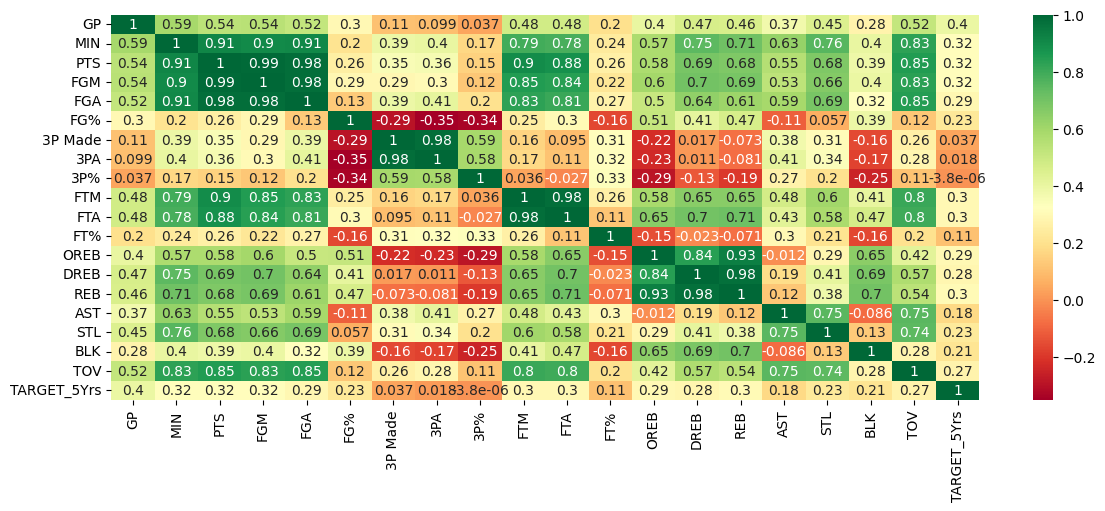

In [8]:
fig = plt.figure(figsize=(14, 5))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")

On remarque 2 phénomenes :
    1 - Plusieurs paramètres présentent une forte corrélation entre eux, ce qui veut dire qu'ils apportent la meme information, il serai alors plus utile de les réduire pour avoir un modèle plus rapide.
    On peut alors supprimer les colonnes :
        - FGM et FGA parce qu'elles sont corrélées avec PTS. (dans tous les cas X_M, et X_A seront toujours corrélées dans la réalité).
        - 3PA (resp FTA) parce qu'elle est corrélée avec 3P Made (resp FTM).
        - REB parce qu'elle est corrélée avec OREB et DREB.
    Attention : On peut se permettre de supprimer ces colonnes parce qu'on sait que la corrélation entre la colonne label 'TARGET_5Yrs' les métriques qui restent n'est pas négligeable, ce qui signifie qu'on ne va pas impacter la qualité de la prédiction.


   2 - Les variables 3P Made et 3P% ne sont pas en corrélation avec le TARGET_5Yrs donc on les supprime aussi

Finalement on se retrouve avec la liste de métriques suivante :

In [321]:
mean_features = ['GP', 'MIN', 'PTS', 'FG%', 'FTM', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV']

In [322]:
# normalize dataset
df_vals = df[paramset].values
X = MinMaxScaler().fit_transform(df_vals)


On peut aller plus loin dans la séléction des features en utilisant la fonction SelectKBest du modéle sklearn qui nous pemets de séléctionner les paramétres les plus importants et les ordonner en fonction de leurs scores.

In [323]:

selector = SelectKBest(f_classif, k=8)

In [324]:
#choix des meilleurs features
best_feats = selector.fit_transform(X, labels)
sorted_indices = np.argsort(selector.scores_)[::-1]
print(selector.get_support())
print(sorted_indices)

[ True  True  True  True False False False False False  True  True False
  True False  True False False False False]
[ 0  1  3  2 14  9 10 12  4 13 18 16  5 17 15 11  6  7  8]


In [325]:

for index in sorted_indices:
    print(f"{paramset[index]}: {selector.scores_[index]:.4f}")


GP: 250.0860
MIN: 150.3204
FGM: 150.0989
PTS: 148.4093
REB: 131.7548
FTM: 129.2893
FTA: 128.5721
OREB: 125.9415
FGA: 125.3340
DREB: 117.9957
TOV: 107.1950
STL: 74.6037
FG%: 72.7824
BLK: 61.7981
AST: 42.4471
FT%: 15.4101
3P Made: 1.7966
3PA: 0.4390
3P%: 0.0000


On modifie notre séléction de features en fcontion de résultats

In [326]:
selected_feats = []
for index in sorted_indices:
    if df[[paramset[index], 'TARGET_5Yrs']].corr()[paramset[index]]['TARGET_5Yrs'] >= 0.2 and selector.scores_[index] >= 10 and paramset[index] in mean_features:
        selected_feats.append(paramset[index])
selected_feats

['GP', 'MIN', 'PTS', 'FTM', 'OREB', 'DREB', 'TOV', 'STL', 'FG%', 'BLK']

Essayons de voir si le jeu de données présente une séparation spacial, pour cela on va réduire sa dimension à 3 en appliquant la méthode de l'ACP et on va visualier sa distribution

In [287]:
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(df[selected_feats], labels, test_size=0.2)
Sigma = scaler.fit_transform(X_train)
P = PCA(3)
P.fit(Sigma)
P

PCA(n_components=3)

In [288]:
# le % de l'infos qu'on préservé
print(P.explained_variance_ratio_)
# les valeurs propres associées
print(P.singular_values_)

[0.6291571  0.12398015 0.11636127]
[14.14744143  6.28021379  6.08418732]


In [291]:
# Projection des données (DataApp) dans le nouvelle base de données
DataAppPCA  = P.transform(Sigma)
# Projection des données de test(DataTest) dans la nouvelle base de données
DataTestPCA  = P.transform(scaler.transform(X_test))
DataTestPCA= np.array(DataTestPCA)

DataTestPCA = np.column_stack((DataTestPCA, y_test))

C:\Users\maris\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


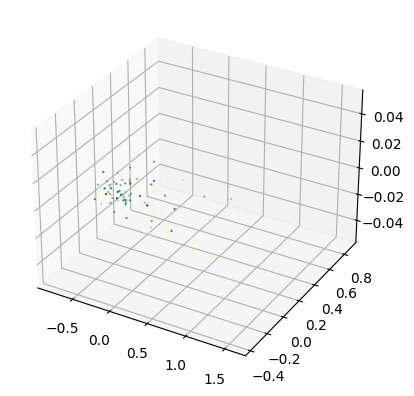

In [290]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})



surf = plt.scatter(DataTestPCA[:,0], DataTestPCA[:,1], DataTestPCA[:,2], c= y_test, cmap = 'summer', alpha= 1)

plt.show()

On ne voit pas de patteren ou de séparation considérable, on reviens alors à l'ensemble de features sélectionnées.

## Choix de l'algorithme

In [327]:
y = df['TARGET_5Yrs'].values


#le jeu de données avec les variables selected_feats
X = MinMaxScaler().fit_transform(df[selected_feats].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# le jeu de données avec toutes les variables
X_all_features = MinMaxScaler().fit_transform(df[selected_feats].values)
X_train_af, X_test_af, y_train_af, y_test_af = train_test_split(X_all_features, y, test_size=0.2)
#on va tester plusieurs modèles avec leurs paramètres par défault en utilisant la fonction du score définie précédement et on va chercher à maximiser le score F1
params_LR = {
   # 'penalty' : [ 'l2', 'elasticne', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' :[100, 300, 500, 600, 750, 900, 1000]
}
params_KNN = {
    'n_neighbors' : [1, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
params_RF = {
    'n_estimators' : [1000, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None, 'auto'],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6]
}
params_GB = {
    'loss' : ['log_loss', 'deviance', 'exponential'],
    'learning_rate':[0.05, 0.075, 0.1],
    'criterion' : ['friedman_mse', 'squared_error', 'mse']
}
params_SVC = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto']
}




In [328]:
# Liste de modèles testés



# à entrainer sur tout le dataset (paramset)
models_Selected_feats = [
    GridSearchCV(estimator=LogisticRegression(), param_grid=params_LR, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_,
    GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_KNN, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_,
   #GridSearchCV(estimator=RandomForestClassifier(), param_grid=params_RF, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_,
    GridSearchCV(estimator=GradientBoostingClassifier(),  param_grid=params_GB, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_,
    GridSearchCV(estimator=SVC(), param_grid=params_SVC, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_ ,
    XGBClassifier(use_label_encoder=False),
    GaussianNB(),
    AdaBoostClassifier()
]


# à entrainer sur le dataset réduit (selectes_feats)
models = [
    GridSearchCV(estimator=LogisticRegression(), param_grid=params_LR, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train_af, y_train_af).best_estimator_,
    GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_KNN, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train_af, y_train_af).best_estimator_,
   #GridSearchCV(estimator=RandomForestClassifier(), param_grid=params_RF, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train, y_train).best_estimator_,
    GridSearchCV(estimator=GradientBoostingClassifier(),  param_grid=params_GB, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train_af, y_train_af).best_estimator_,
    GridSearchCV(estimator=SVC(), param_grid=params_SVC, n_jobs=-1, cv=5, scoring=f1_score).fit(X_train_af, y_train_af).best_estimator_ ,
    XGBClassifier(use_label_encoder=False),
    GaussianNB(),
    AdaBoostClassifier()
]


C:\Users\maris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\maris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\maris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan na

Les Résultas sur le dataset réduit :

                   model_name  f1_score    recall  precision
0          LogisticRegression  0.773996  0.819368   0.737706
3                         SVC  0.770710  0.807441   0.741933
2  GradientBoostingClassifier  0.763732  0.793241   0.740202
6          AdaBoostClassifier  0.751339  0.786188   0.723020
4               XGBClassifier  0.727212  0.751585   0.712480
1        KNeighborsClassifier  0.680109  0.682182   0.682691
5                  GaussianNB  0.649007  0.543608   0.815977


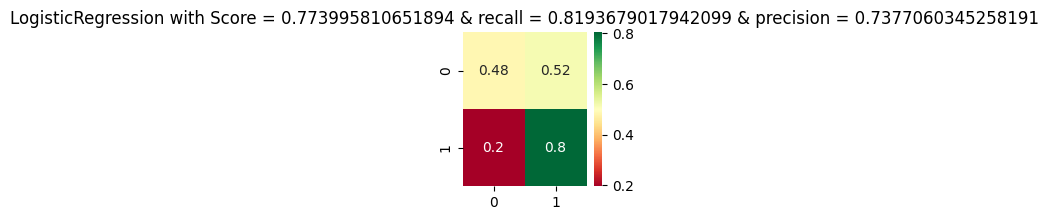

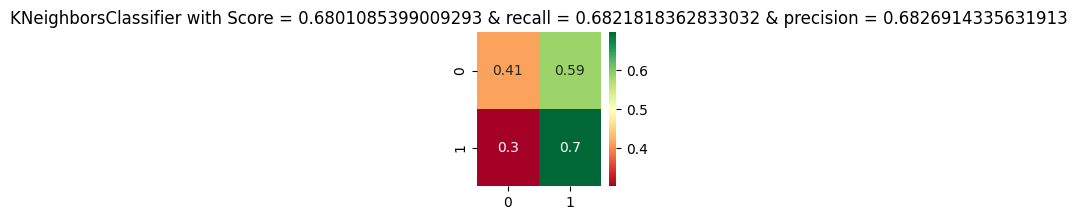

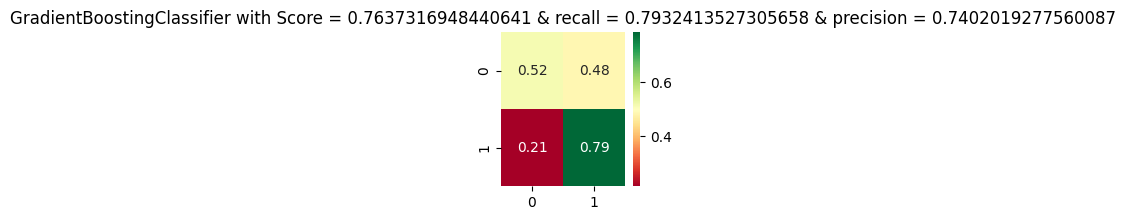

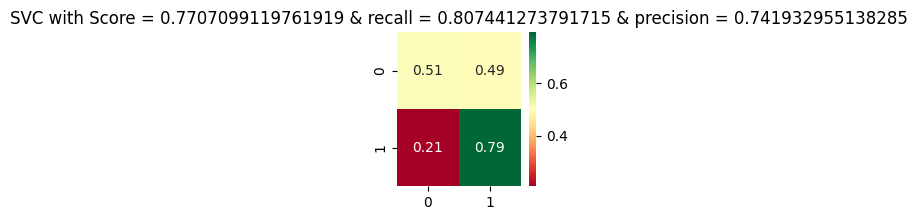

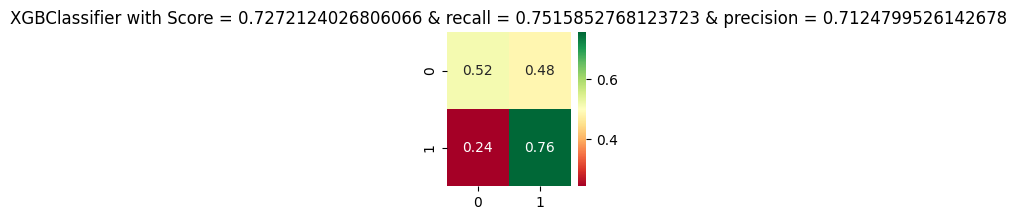

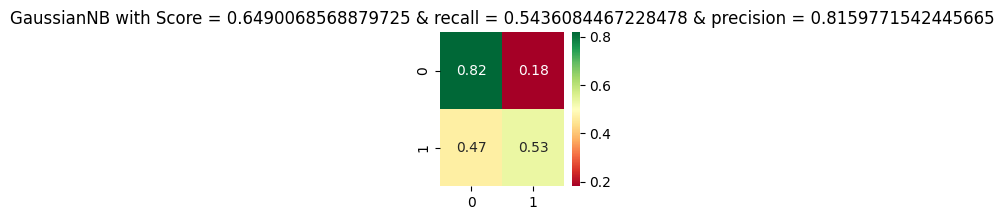

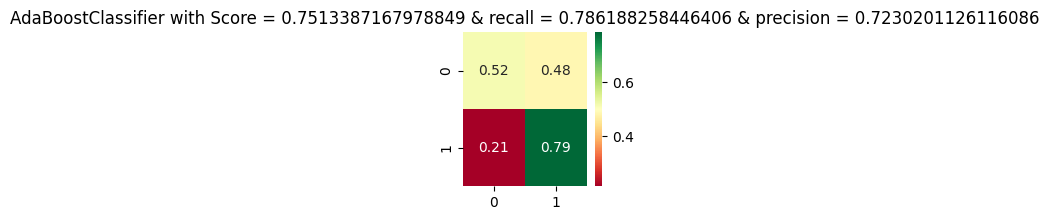

In [329]:

results  = pd.DataFrame(columns = ['model_name', 'f1_score', 'recall', 'precision'])
for model in models_Selected_feats:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion_mat = np.zeros((2, 2))
    confusion_mat[0] = np.array(confusion_matrix(y_pred, y_test))[:, 0]/(y_test.shape[0] - sum(y_test))
    confusion_mat[1] = np.array(confusion_matrix(y_pred, y_test))[:, 1]/sum(y_test)

    score_result, recall, precision = score_classifier(X,model,labels, cv = 15)
    entry = [model.__class__.__name__, score_result, recall, precision]
    results.loc[len(results.index)] = entry
    df_cm = pd.DataFrame(confusion_mat, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
    plt.figure(figsize = (2,2))
    plt.title(model.__class__.__name__ + f' with Score = {score_result}' + f' & recall = {recall}' + f' & precision = {precision}')
    sns.heatmap(df_cm, annot=True, cmap="RdYlGn")
results = results.sort_values(by = 'f1_score', ascending=False)
print(results)

Les Résultas sur le dataset initial :

,model_name,f1_score,recall,precision
0,LogisticRegression,0.773996,0.819368,0.737706
3,SVC,0.770710,0.807441,0.741933
2,GradientBoostingClassifier,0.764016,0.794432,0.739652
6,AdaBoostClassifier,0.751339,0.786188,0.723020
4,XGBClassifier,0.727212,0.751585,0.712480
1,KNeighborsClassifier,0.680109,0.682182,0.682691
5,GaussianNB,0.649007,0.543608,0.815977


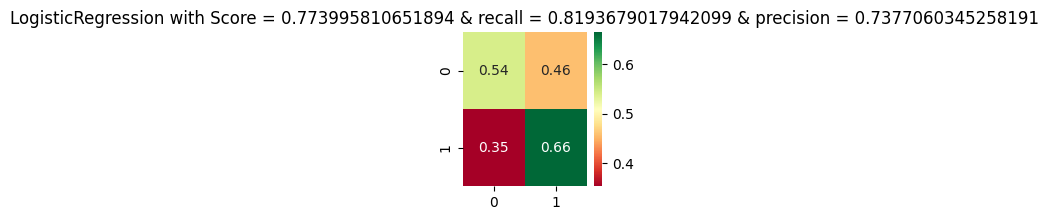

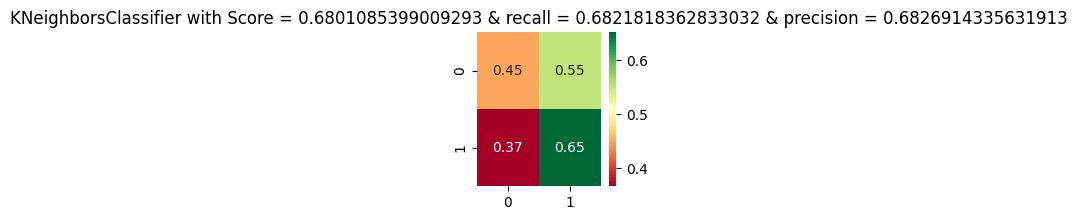

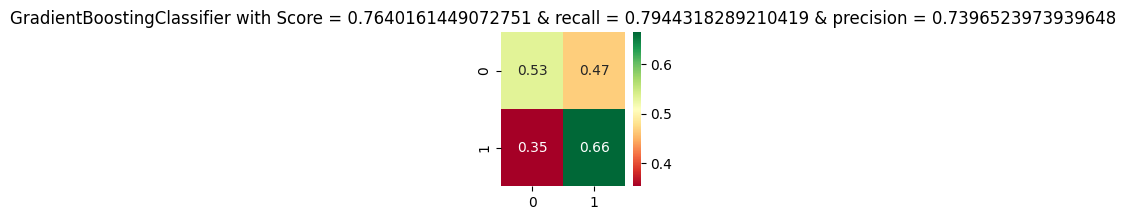

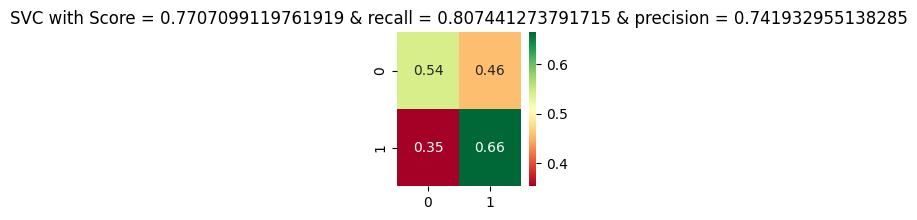

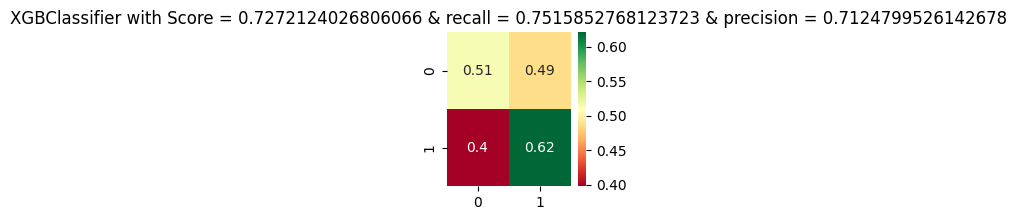

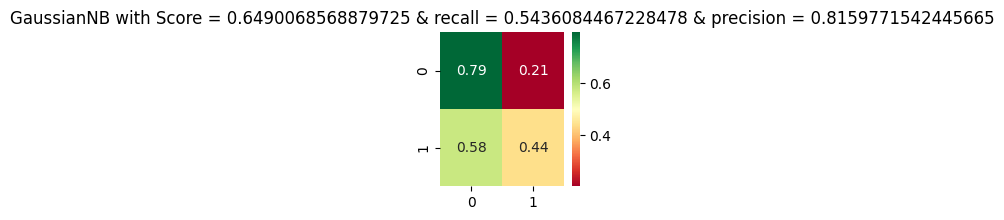

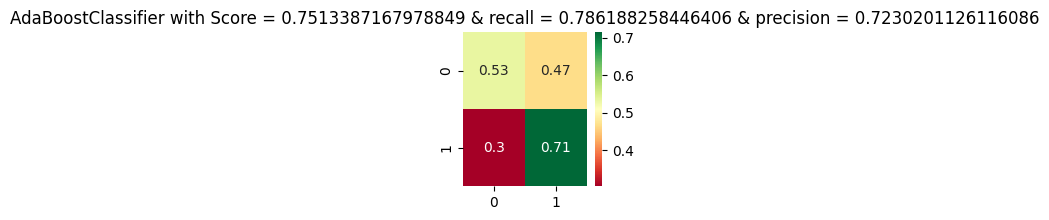

In [303]:
results  = pd.DataFrame(columns = ['model_name', 'f1_score', 'recall', 'precision'])
for model in models:

    model.fit(X_train_af, y_train_af)
    y_pred = model.predict(X_test_af)
    confusion_mat = np.zeros((2, 2))
    confusion_mat[0] = np.array(confusion_matrix(y_pred, y_test_af))[:, 0]/(y_test_af.shape[0] - sum(y_test_af))
    confusion_mat[1] = np.array(confusion_matrix(y_pred, y_test))[:, 1]/sum(y_test_af)

    score_result, recall, precision = score_classifier(X_all_features,model,labels, cv = 15)
    entry = [model.__class__.__name__, score_result, recall, precision]
    results.loc[len(results.index)] = entry
    df_cm = pd.DataFrame(confusion_mat, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
    plt.figure(figsize = (2,2))
    plt.title(model.__class__.__name__ + f' with Score = {score_result}' + f' & recall = {recall}' + f' & precision = {precision}')
    sns.heatmap(df_cm, annot=True, cmap="RdYlGn")
results = results.sort_values(by = 'f1_score', ascending=False)
results

On remarque que, pour les 2 datasets, le modèles qui donne les meilleures prédictions est la régression logistique.
On obtient le meme score dans les 2 cas donc on applique la selection de paramètres qu'on a définis

In [333]:
model = models_Selected_feats[0]
model

LogisticRegression(solver='newton-cg')

In [334]:
model_pipeline = make_pipeline(MinMaxScaler(), model)
final_features = ['GP', 'MIN', 'PTS', 'FTM', 'OREB', 'DREB', 'TOV', 'STL', 'FG%', 'BLK']
Data = df[final_features].values
Labels = df['TARGET_5Yrs'].values

In [335]:
X_train, X_test, y_train, y_test = train_test_split(Data, Labels, train_size=0.2, random_state=50)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])

In [336]:
y_pred = model_pipeline.predict(X_test)
score = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print(score)
print(confusion_mat)

0.7709815078236131
[[208 196]
 [126 542]]


In [337]:
import joblib
joblib.dump(model_pipeline, 'Prediction_model')

['Prediction_model']

In [338]:
model = joblib.load('Prediction_model')
X = Data[67:70]
print(X)
y = model.predict(X)
y

[[82.  28.5 15.7  1.9  0.8  2.1  1.6  0.8 42.5  0.3]
 [82.  27.4  7.2  0.8  1.3  1.6  2.2  2.  45.   0.2]
 [81.  25.9  7.1  2.2  3.4  4.6  0.9  0.6 51.2  1.5]]


array([1., 1., 1.])